# Facebook Prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [14]:
import warnings
warnings.simplefilter('ignore')

In [2]:
# libraries
import numpy as np
import pandas as pd
from prophet import Prophet

In [3]:
# load the data
# YYYY-MM-DD
df = pd.read_csv('../../_data/nyc_data.csv')
future_df = pd.read_csv('../../_data/future.csv')
future_df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2021,NaN,0,0,0,5.00,154.221
1,1/2/2021,NaN,0,0,0,11.11,264.805
2,1/3/2021,NaN,0,0,0,3.89,115.499
3,1/4/2021,NaN,0,0,0,6.67,124.650
4,1/5/2021,NaN,0,0,0,5.56,77.968


In [4]:
# merge both datasets
df = pd.concat([df, future_df])
df = df.reset_index(drop=True)
df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752
2222,1/31/2021,NaN,0,0,0,4.44,158.620


In [5]:
# Rename variable
df = df.rename(columns={'Demand': 'y',
                        'Date': 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [6]:
# Date variable
df.ds = pd.to_datetime(df.ds,
                       format="%m/%d/%Y")
df.ds

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2218   2021-01-27
2219   2021-01-28
2220   2021-01-29
2221   2021-01-30
2222   2021-01-31
Name: ds, Length: 2223, dtype: datetime64[ns]

## Holidays

In [7]:
# Easter
dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': dates,
                       'lower_window': -5,
                       'upper_window': 2})

In [8]:
# Thanksgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                             'ds': dates,
                             'lower_window': -3,
                             'upper_window': 6})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


In [9]:
# Combining events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [10]:
# removing the holiday columns
df = df.drop(columns=["Easter", "Thanksgiving"])
df.head(0)

,ds,y,Christmas,Temperature,Marketing


## Facebook Prophet model

In [11]:
# Split the data
training = df.iloc[:-31,:]
future_df = df.iloc[-31:,:]

In [12]:
# Fetch the parameters
parameters = pd.read_csv("../../02 Parameter Tuning/01 Facebook Prophet/out/best_params_prophet.csv",
                         index_col=0)
parameters

,56
changepoint_prior_scale,0.01
holidays_prior_scale,25
seasonality_mode,additive
seasonality_prior_scale,1
rmse,48.010188325940554


In [16]:
# Extract the values
changepoint_prior_scale = float(parameters.loc["changepoint_prior_scale"][0])
holidays_prior_scale = float(parameters.loc["holidays_prior_scale"][0])
seasonality_prior_scale = float(parameters.loc["seasonality_prior_scale"][0])
seasonality_mode = parameters.loc["seasonality_mode"][0]
changepoint_prior_scale, holidays_prior_scale, seasonality_prior_scale, seasonality_mode

(0.01, 25.0, 1.0, 'additive')

In [17]:
# FB model
m = Prophet(holidays = holidays,
            seasonality_mode=seasonality_mode,
            seasonality_prior_scale=seasonality_prior_scale,
            holidays_prior_scale=holidays_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(training)

15:01:36 - cmdstanpy - INFO - Chain [1] start processing
15:01:36 - cmdstanpy - INFO - Chain [1] done processing


## Forecasting

In [18]:
# make a future dataframe
future = m.make_future_dataframe(periods=len(future_df),
                                 freq = "D") #W for weekly or M for monthly
future = pd.concat([future, df.iloc[:, 2:]], axis=1)
future.head()

,ds,Christmas,Temperature,Marketing
0,2015-01-01,0,3.68,41.305
1,2015-01-02,0,4.73,131.574
2,2015-01-03,0,7.23,162.700
3,2015-01-04,0,10.96,160.281
4,2015-01-05,0,6.92,51.077


In [19]:
# Forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Marketing,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,594.469215,619.871647,760.714589,594.469215,594.469215,0.0,0.0,0.0,-3.428173,...,-4.043642,-4.043642,-4.043642,89.966394,89.966394,89.966394,0.0,0.0,0.0,687.962160
1,2015-01-02,594.586254,536.052492,671.508699,594.586254,594.586254,0.0,0.0,0.0,0.196690,...,-89.464299,-89.464299,-89.464299,88.616262,88.616262,88.616262,0.0,0.0,0.0,603.914246
2,2015-01-03,594.703293,646.870966,783.562856,594.703293,594.703293,0.0,0.0,0.0,1.446592,...,25.252465,25.252465,25.252465,87.431061,87.431061,87.431061,0.0,0.0,0.0,716.386496
3,2015-01-04,594.820332,563.005035,694.995420,594.820332,594.820332,0.0,0.0,0.0,1.349455,...,-55.619375,-55.619375,-55.619375,86.429660,86.429660,86.429660,0.0,0.0,0.0,630.913182
4,2015-01-05,594.937371,687.698875,831.148197,594.937371,594.937371,0.0,0.0,0.0,-3.035766,...,74.333016,74.333016,74.333016,85.625344,85.625344,85.625344,0.0,0.0,0.0,759.713904


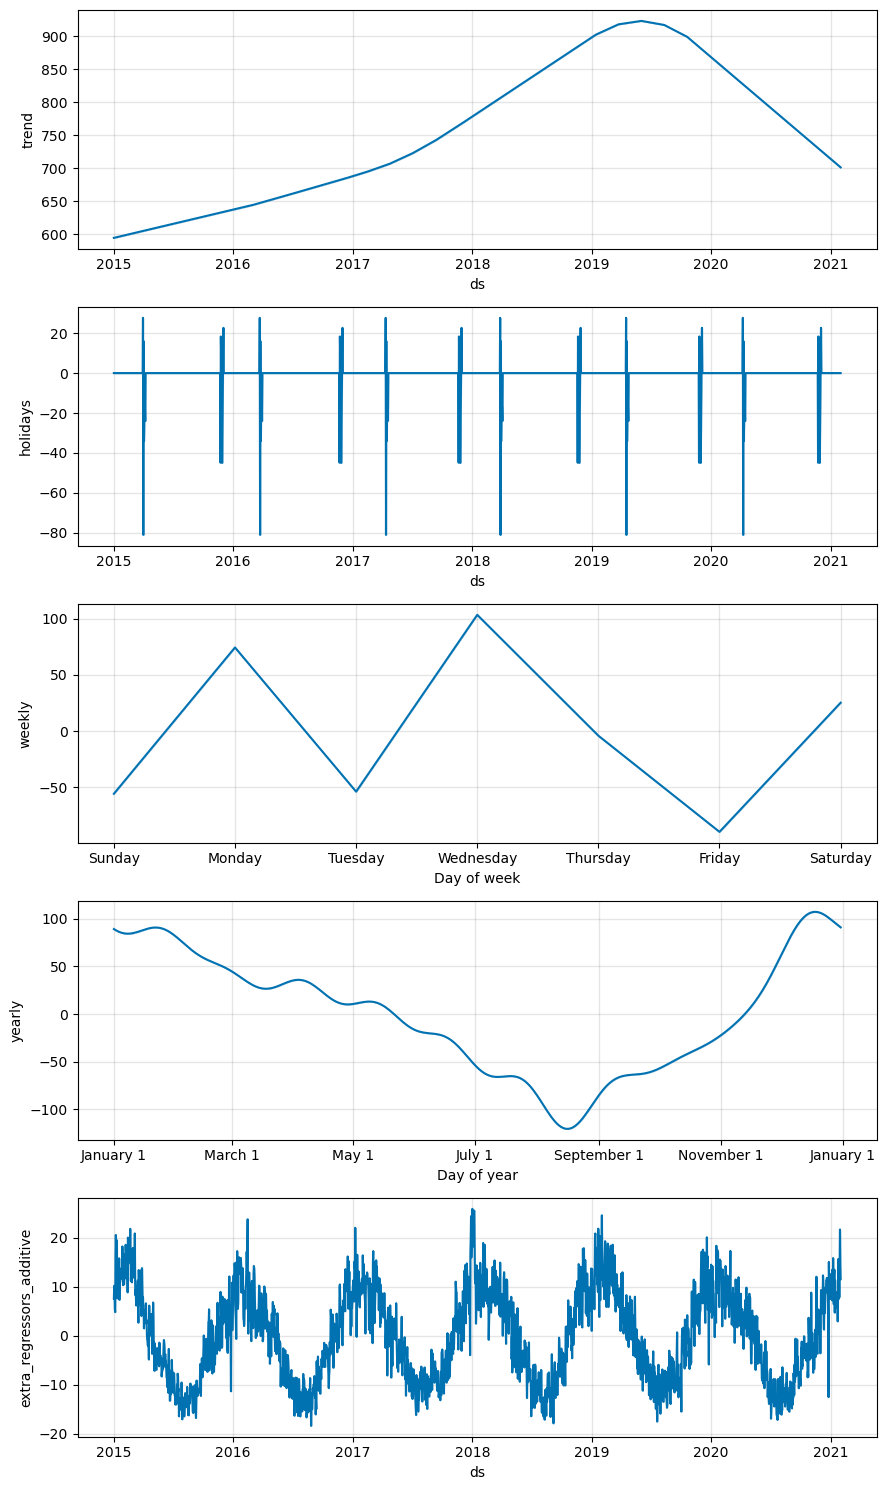

In [20]:
# Plotting
m.plot_components(forecast);

In [21]:
# extract the predictions
predictions_prophet = forecast.yhat[-len(future_df):].rename("prophet")
predictions_prophet.index = future_df["ds"]
predictions_prophet

ds
2021-01-01    724.480101
2021-01-02    836.016157
2021-01-03    754.639245
2021-01-04    880.935735
2021-01-05    750.931655
2021-01-06    913.329355
2021-01-07    801.046546
2021-01-08    721.684700
2021-01-09    831.061033
2021-01-10    745.636109
2021-01-11    880.298818
2021-01-12    754.636092
2021-01-13    903.128515
2021-01-14    802.669866
2021-01-15    712.724047
2021-01-16    828.901537
2021-01-17    749.436795
2021-01-18    879.529224
2021-01-19    748.559125
2021-01-20    905.409114
2021-01-21    800.865027
2021-01-22    709.343338
2021-01-23    830.407751
2021-01-24    754.636610
2021-01-25    875.515892
2021-01-26    752.981914
2021-01-27    902.399257
2021-01-28    801.431234
2021-01-29    720.293940
2021-01-30    826.077422
2021-01-31    740.255247
Name: prophet, dtype: float64

In [22]:
# export
predictions_prophet.to_csv("./out/predictions_prophet.csv")